# Turn the data into Anndata format for further analysis

In [2]:
#Importing the relevant libraries for doing the analysis (there are probably still too many that you do not need)
import pandas as pd
from pyFlowSOM import map_data_to_nodes, som
import seaborn as sns 
import numpy as np
import scanpy as sc
import squidpy as sq
import os
import gc
import random
from matplotlib import rcParams
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.io  import imread, imsave
import skimage.io
import anndata as ad
import seaborn as sns 
from scipy import stats
import warnings
import shutil
import math
import openpyxl


In [3]:
# Setting up the handling with scanpy

# This line sets the verbosity level of the Scanpy library. In this case, it sets it to the highest level (3), which includes errors, warnings, info, and hints
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3            

# This line prints a header for the log messages, indicating that the log messages are from Scanpy
sc.logging.print_header()

# This line temporarily suppresses the display of warning messages. 
# It sets a filter to ignore any warnings that might occur during the execution of the code.
warnings.filterwarnings('ignore')

# This line sets the default parameters for the figures generated by Scanpy
# It specifies the DPI (dots per inch) of the figures to be 80 and sets the face color of the figures to white.
sc.settings.set_figure_params(dpi=80, facecolor='white')

/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/umap/dist

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.23.4 scipy==1.9.1 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.6 pynndescent==0.5.10


/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [4]:
#set up the base directory
base_dir = '/Users/teresaglauner/ark-analysis/data/COL102A_rosetta_1_cellpose_withASCT2_GLUT1_membrane/'

#set up the directory with the cell tables after running deepcell or cellpose
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table_25")
segmentation_dir = os.path.join(base_dir, "segmentation/cellpose_visualization_nuclei_modified")
image_dir = os.path.join(base_dir, "image_data/")

#set up the directory for saving the plots of this notebook
preprocessing_python_dir = os.path.join(base_dir, "preprocessing_python_test/")

In [7]:
# Read the cell size normalized table
df = pd.read_csv(os.path.join(cell_table_dir,'cell_table_size_normalized_processed_TG_500.csv'))

In [8]:
# Getting the names of the columns in order to define the relevant channels
df.columns

Index(['cell_size', 'ARG1', 'ASCT2', 'ATP5A', 'CA9', 'CD14', 'CD163', 'CD20',
       'CD31', 'CD3e', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8', 'CD98', 'CPT1A',
       'CS', 'CytC', 'DCN', 'FoxP3', 'GLS', 'GLUT1', 'GS', 'HLADRa', 'Ki67',
       'LDH', 'MCT1', 'MPO', 'MSH2', 'MSH6', 'PD1', 'PDL1', 'PKM2', 'PanCK',
       'SMA', 'STING1', 'Vimentin', 'membrane', 'nuclei', 'label', 'area',
       'eccentricity', 'major_axis_length', 'minor_axis_length', 'perimeter',
       'convex_area', 'equivalent_diameter', 'centroid-0', 'centroid-1',
       'major_minor_axis_ratio', 'perim_square_over_area',
       'major_axis_equiv_diam_ratio', 'convex_hull_resid', 'centroid_dif',
       'num_concavities', 'fov'],
      dtype='object')

In [9]:
# Define channels and background list to be removed
channels = ['ARG1', 'ASCT2', 'ATP5A', 'CA9', 'CD14','CD163', 'STING1','CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'CD98', 'CPT1A', 'CS', 'DCN', 'GS', 'MPO', 'MSH2', 'MSH6',
       'CytC', 'FoxP3', 'GLS', 'GLUT1', 'HLADRa', 'Ki67',
       'LDH', 'MCT1', 'PDL1', 'PD1', 'PKM2', 'PanCK', 'SMA', 'Vimentin']

channels_with_nuclei = ['ARG1', 'ASCT2', 'ATP5A', 'CA9', 'CD14','CD163', 'STING1','CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'CD98', 'CPT1A', 'CS', 'DCN', 'GS', 'MPO', 'MSH2', 'MSH6',
       'CytC', 'FoxP3', 'GLS', 'GLUT1', 'HLADRa', 'Ki67',
       'LDH', 'MCT1', 'PDL1', 'PD1', 'PKM2', 'PanCK', 'SMA', 'Vimentin', 'nuclei', 'membrane']

metabolic_and_other_channels= ['ARG1', 'ASCT2', 'ATP5A', 'CA9', 'STING1',
       'CD98', 'CPT1A', 'CS', 'GS', 'MSH2', 'MSH6',
       'CytC', 'GLS', 'GLUT1', 'Ki67',
       'LDH', 'MCT1', 'PDL1', 'PD1', 'PKM2']

metabolic_channels= ['ARG1', 'ASCT2', 'ATP5A', 'CD98', 'CPT1A', 'CS', 'GS', 
       'CytC', 'GLS', 'GLUT1', 'LDH', 'MCT1', 'PKM2']

other_channels= ['CA9', 'STING1','MSH2', 'MSH6', 'Ki67','PDL1', 'PD1']

lineage_channels= ['CD14','CD163', 'CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'DCN', 'MPO', 'HLADRa','PanCK', 'SMA', 'Vimentin']

other= ['CD45','PanCK', 'MSH2', 'MSH6', 'SMA']

morpho= ['area','eccentricity', 'major_axis_length', 'minor_axis_length', 'perimeter',
       'convex_area', 'equivalent_diameter',
       'major_minor_axis_ratio', 'perim_square_over_area',
       'major_axis_equiv_diam_ratio', 'convex_hull_resid', 'centroid_dif',
       'num_concavities', 'cell_size']

lineage_channels_with_morpho= ['CD14','CD163', 'CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'DCN', 'MPO', 'HLADRa','PanCK', 'SMA', 'Vimentin','cell_size']


In [11]:
# Display the statistics of the  channels
df[channels].describe()

,ARG1,ASCT2,ATP5A,CA9,CD14,CD163,STING1,CD3e,CD31,CD4,...,HLADRa,Ki67,LDH,MCT1,PDL1,PD1,PKM2,PanCK,SMA,Vimentin
count,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,...,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000
mean,0.411089,0.394712,0.474013,0.372231,0.317972,0.115736,0.461425,0.170912,0.212293,0.288981,...,0.183748,0.263849,0.462075,0.306950,0.245715,0.236217,0.454961,0.372342,0.136716,0.242919
std,0.192005,0.220890,0.215441,0.179953,0.196524,0.172938,0.208183,0.186806,0.190149,0.216223,...,0.159859,0.210391,0.222508,0.238778,0.176055,0.197013,0.202325,0.228255,0.227818,0.259709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.275819,0.217486,0.331475,0.240161,0.170673,0.007003,0.317090,0.047465,0.063726,0.102590,...,0.074793,0.101393,0.304186,0.083779,0.103973,0.060129,0.316319,0.175559,0.000000,0.027429
50%,0.411560,0.403173,0.494866,0.367070,0.272163,0.043572,0.474876,0.111231,0.161749,0.266514,...,0.143772,0.207599,0.483199,0.278980,0.226067,0.205375,0.465610,0.377472,0.001712,0.093823
75%,0.540892,0.560045,0.631318,0.490473,0.429631,0.144198,0.613187,0.212429,0.307219,0.433871,...,0.238895,0.370378,0.628985,0.492865,0.355771,0.372398,0.600084,0.546939,0.217174,0.463694
max,1.193694,1.192247,1.123570,1.236516,1.269858,1.421837,1.281330,1.389960,1.219095,1.675808,...,1.520827,1.251159,1.311149,1.243042,1.273367,1.611569,1.137335,1.196974,1.093675,1.199122


In [13]:
# Decide what channels you want to use to do the clustering, e.g. lineage_channels, metabolic_channels
df_channels_only = df[lineage_channels].copy()
df_channels_only.describe()


,CD14,CD163,CD3e,CD31,CD4,CD45,CD68,CD7,CD8,DCN,MPO,HLADRa,PanCK,SMA,Vimentin
count,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000,493940.000000
mean,0.317972,0.115736,0.170912,0.212293,0.288981,0.265392,0.164330,0.145235,0.080993,0.186824,0.076521,0.183748,0.372342,0.136716,0.242919
std,0.196524,0.172938,0.186806,0.190149,0.216223,0.227738,0.185471,0.166352,0.143448,0.197554,0.161993,0.159859,0.228255,0.227818,0.259709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.170673,0.007003,0.047465,0.063726,0.102590,0.090982,0.031598,0.040355,0.000513,0.020396,0.006877,0.074793,0.175559,0.000000,0.027429
50%,0.272163,0.043572,0.111231,0.161749,0.266514,0.165799,0.093814,0.086795,0.020325,0.121661,0.017817,0.143772,0.377472,0.001712,0.093823
75%,0.429631,0.144198,0.212429,0.307219,0.433871,0.418272,0.228913,0.176761,0.097156,0.301379,0.043927,0.238895,0.546939,0.217174,0.463694
max,1.269858,1.421837,1.389960,1.219095,1.675808,1.179083,1.291756,1.333191,1.278440,1.564792,1.184870,1.520827,1.196974,1.093675,1.199122


# Run PyFlowsome

In [14]:
#Basic usage - Here you do not need to change anything

#First step to do pyflowsome
example_som_input_arr = df_channels_only.to_numpy()

#train the SOM
node_output = som(example_som_input_arr, xdim=10, ydim=10, rlen=10)

#use trained SOM to assign clusters to each observation in your data
clusters, dists = map_data_to_nodes(node_output, example_som_input_arr)

In [15]:
# To put the data back into dataframes - Here you do not need to change anything

eno = pd.DataFrame(data=node_output, columns=df_channels_only.columns)
eco = pd.DataFrame(data=clusters, columns=["cluster"])

In [16]:
# To export to csv - Rename the files as you want to 
eno.to_csv(os.path.join(preprocessing_python_dir, 'CRC_node_test.csv'), index=False)
eco.to_csv(os.path.join(preprocessing_python_dir, 'CRC_clusters_test.csv'), index=False)

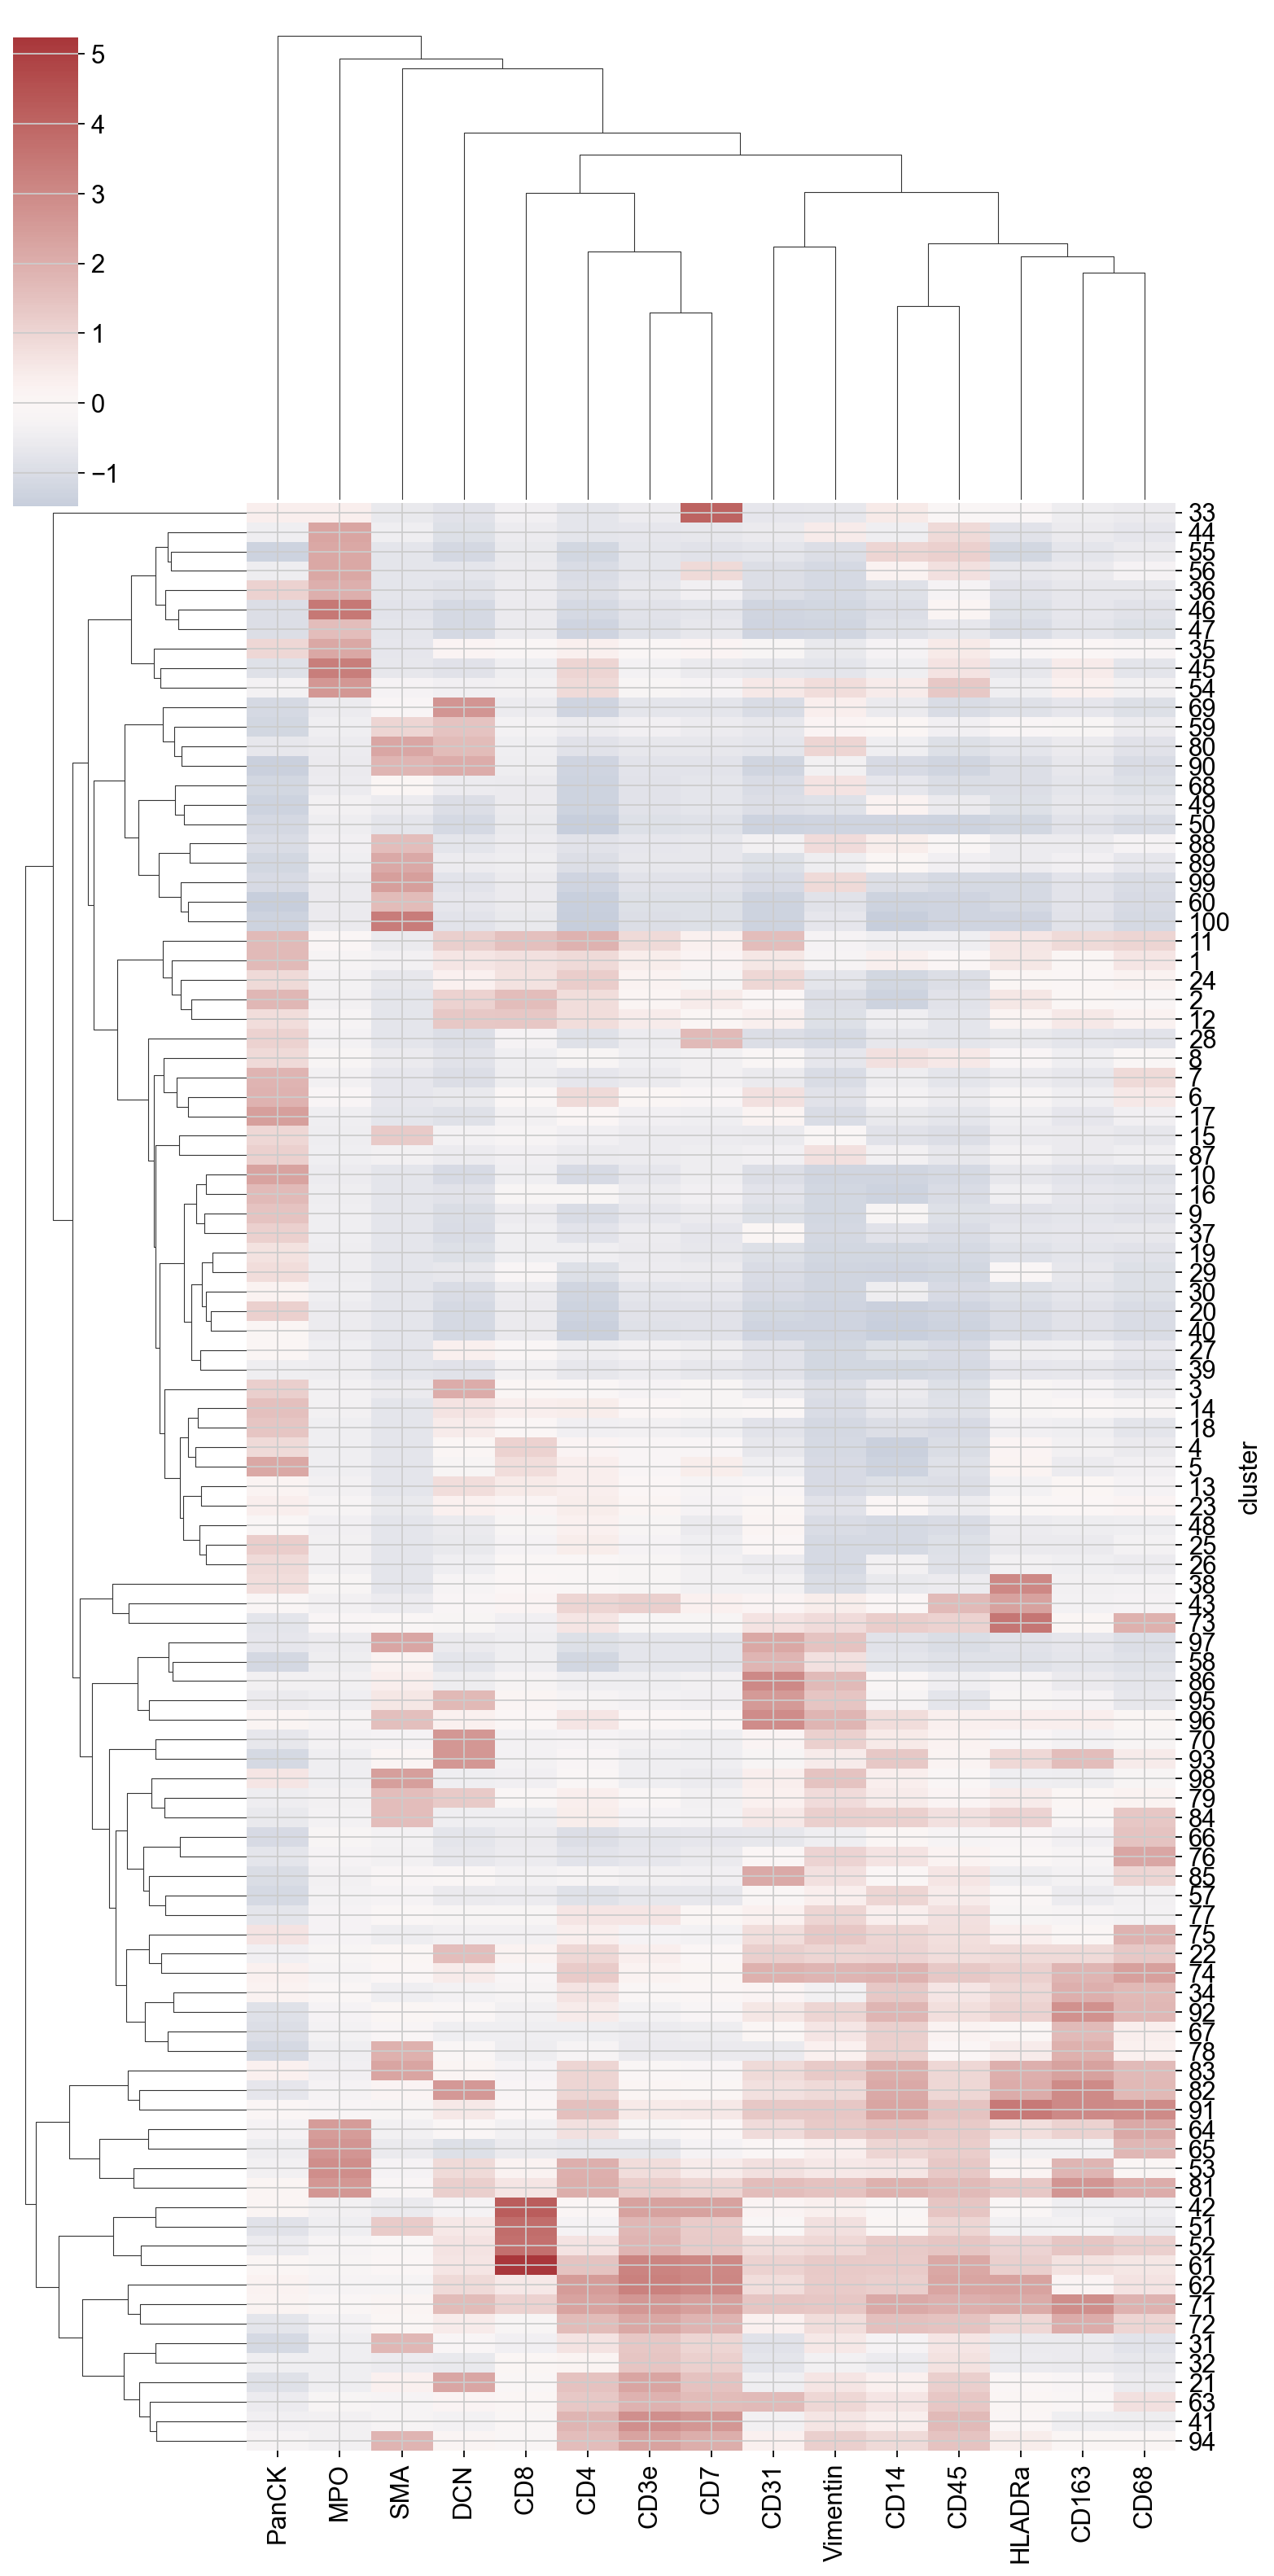

In [17]:
#To plot the output as a heatmap - Rename the file as you want to 

#Append results to the input data
df_channels_only['cluster'] = clusters

#Find mean of each cluster
df_channels_only_mean = df_channels_only.groupby(['cluster']).mean()

# Set the size of the heatmap figure (adjust the height as needed)
heatmap_height = len(df_channels_only_mean) * 0.2  # You can adjust the multiplier as needed
heatmap_width = 10  # Width of the heatmap figure

#Make heatmap
sns_plot = sns.clustermap(df_channels_only_mean, z_score=1, cmap="vlag", center=0, yticklabels=True, xticklabels=True, figsize=(heatmap_width, heatmap_height))

# Save the plot to a file
save_path = os.path.join(preprocessing_python_dir, 'pyflowsome_heatmap_lineage_channels_5000.png')
plt.savefig(save_path, dpi=300, format='png')

# Display the figure
plt.show()

In [19]:
# Convert z-scores from the heatmap into a dataframe
z_scores = sns_plot.data2d
z_scores_df = pd.DataFrame(z_scores)


In [20]:
# Save the table with the z scores and the cluster names as a csv file - Rename the file
z_scores_df
z_scores_df.to_csv(os.path.join(preprocessing_python_dir, 'zscore.csv'), index=True)

In [24]:
# Now you want to create a dataframe that contains the means of the channels in each cluster and not the z-score
df_channels_only_mean = df_channels_only.groupby(['cluster']).mean()

In [25]:
# Here is the code to add the cluster number

cluster_order = sns_plot.dendrogram_row.reordered_ind
cluster_order = [idx + 1 for idx in cluster_order]

# Print the order of the clusters
print("Cluster Order:", cluster_order)

Cluster Order: [33, 44, 55, 56, 36, 46, 47, 35, 45, 54, 69, 59, 80, 90, 68, 49, 50, 88, 89, 99, 60, 100, 11, 1, 24, 2, 12, 28, 8, 7, 6, 17, 15, 87, 10, 16, 9, 37, 19, 29, 30, 20, 40, 27, 39, 3, 14, 18, 4, 5, 13, 23, 48, 25, 26, 38, 43, 73, 97, 58, 86, 95, 96, 70, 93, 98, 79, 84, 66, 76, 85, 57, 77, 75, 22, 74, 34, 92, 67, 78, 83, 82, 91, 64, 65, 53, 81, 42, 51, 52, 61, 62, 71, 72, 31, 32, 21, 63, 41, 94]


In [26]:
# Display the table 
df_channels_only_mean

,CD14,CD163,CD3e,CD31,CD4,CD45,CD68,CD7,CD8,DCN,MPO,HLADRa,PanCK,SMA,Vimentin
cluster,,,,,,,,,,,,,,,
1,0.438796,0.175926,0.278378,0.361367,0.521563,0.340441,0.325348,0.205875,0.188566,0.320357,0.065190,0.301977,0.663118,0.082431,0.261719
2,0.150824,0.164421,0.225085,0.256297,0.504103,0.168365,0.199400,0.247426,0.315942,0.401105,0.045368,0.299107,0.679398,0.013018,0.088221
3,0.282302,0.107805,0.149056,0.161985,0.312196,0.148717,0.121582,0.142488,0.104153,0.575708,0.042725,0.185764,0.565659,0.041253,0.093777
4,0.131805,0.088988,0.174093,0.140043,0.366130,0.126907,0.111026,0.153812,0.239498,0.223630,0.032011,0.242528,0.510557,0.005602,0.048851
5,0.150326,0.066361,0.175698,0.179292,0.406621,0.156225,0.142239,0.243392,0.200006,0.173795,0.032682,0.247390,0.757947,0.006660,0.062279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.521563,0.225013,0.202612,0.784481,0.459834,0.420185,0.228205,0.155297,0.086493,0.260791,0.065724,0.271195,0.358627,0.491920,0.773240
97,0.239727,0.031672,0.061681,0.655324,0.154961,0.129977,0.041348,0.058113,0.031236,0.114181,0.017636,0.098432,0.204598,0.626077,0.688321
98,0.444099,0.071447,0.119683,0.320907,0.316261,0.332241,0.177220,0.089057,0.033228,0.138395,0.032390,0.153677,0.452477,0.667906,0.678888


In [27]:
# Save the table - Rename the file as you like to 
df_channels_only_mean.to_csv(os.path.join(preprocessing_python_dir, 'cluster_name.csv'), index=True)

In [28]:
# Read the table so that we are now working with this table 
df = pd.read_csv(os.path.join(preprocessing_python_dir, 'cluster_name.csv'))

In [29]:
# Display the table - you see that the order of the cluster is not yet the one from the heatmap
df

,cluster,CD14,CD163,CD3e,CD31,CD4,CD45,CD68,CD7,CD8,DCN,MPO,HLADRa,PanCK,SMA,Vimentin
0,1,0.438796,0.175926,0.278378,0.361367,0.521563,0.340441,0.325348,0.205875,0.188566,0.320357,0.065190,0.301977,0.663118,0.082431,0.261719
1,2,0.150824,0.164421,0.225085,0.256297,0.504103,0.168365,0.199400,0.247426,0.315942,0.401105,0.045368,0.299107,0.679398,0.013018,0.088221
2,3,0.282302,0.107805,0.149056,0.161985,0.312196,0.148717,0.121582,0.142488,0.104153,0.575708,0.042725,0.185764,0.565659,0.041253,0.093777
3,4,0.131805,0.088988,0.174093,0.140043,0.366130,0.126907,0.111026,0.153812,0.239498,0.223630,0.032011,0.242528,0.510557,0.005602,0.048851
4,5,0.150326,0.066361,0.175698,0.179292,0.406621,0.156225,0.142239,0.243392,0.200006,0.173795,0.032682,0.247390,0.757947,0.006660,0.062279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.521563,0.225013,0.202612,0.784481,0.459834,0.420185,0.228205,0.155297,0.086493,0.260791,0.065724,0.271195,0.358627,0.491920,0.773240
96,97,0.239727,0.031672,0.061681,0.655324,0.154961,0.129977,0.041348,0.058113,0.031236,0.114181,0.017636,0.098432,0.204598,0.626077,0.688321
97,98,0.444099,0.071447,0.119683,0.320907,0.316261,0.332241,0.177220,0.089057,0.033228,0.138395,0.032390,0.153677,0.452477,0.667906,0.678888
98,99,0.211464,0.015725,0.041154,0.069920,0.076259,0.104681,0.030106,0.042535,0.008218,0.081342,0.009264,0.061368,0.136865,0.669143,0.535785


In [30]:
# Create a new dataframe with rows ordered by the 'cluster_order' - Now, 'df_ordered' contains the DataFrame with rows reordered based on the 'cluster_order'.
df_ordered = df.set_index('cluster').loc[cluster_order].reset_index()

In [31]:
# Display the table
df_ordered

,cluster,CD14,CD163,CD3e,CD31,CD4,CD45,CD68,CD7,CD8,DCN,MPO,HLADRa,PanCK,SMA,Vimentin
0,33,0.468625,0.068591,0.100714,0.134928,0.179569,0.333352,0.107370,0.848744,0.034213,0.077116,0.181906,0.192783,0.409812,0.032881,0.159482
1,44,0.306359,0.053545,0.068550,0.153300,0.179764,0.539358,0.088949,0.072934,0.015155,0.064083,0.541522,0.100802,0.247943,0.068055,0.433366
2,55,0.565839,0.026983,0.062843,0.124169,0.087175,0.600142,0.105846,0.043019,0.004648,0.015881,0.528790,0.050218,0.086994,0.007804,0.097154
3,56,0.421800,0.050084,0.063408,0.091675,0.124594,0.506533,0.165517,0.319313,0.013494,0.090523,0.523156,0.125620,0.244628,0.003358,0.055556
4,36,0.231625,0.036594,0.078781,0.092446,0.136424,0.285363,0.090784,0.110941,0.020969,0.065286,0.483952,0.097611,0.545164,0.004395,0.048640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,32,0.291287,0.052272,0.474816,0.132503,0.374044,0.501466,0.089581,0.362276,0.104269,0.109249,0.030413,0.144026,0.251004,0.055838,0.239304
96,21,0.428220,0.126723,0.635469,0.180946,0.642435,0.608701,0.118130,0.426758,0.081711,0.600310,0.033200,0.219958,0.176627,0.217955,0.470329
97,63,0.490234,0.134859,0.565558,0.564313,0.614752,0.654241,0.355874,0.449485,0.101881,0.239621,0.077029,0.230549,0.235994,0.108420,0.565575
98,41,0.443223,0.074770,0.746248,0.197311,0.717557,0.728802,0.124217,0.615565,0.077021,0.158471,0.045012,0.215584,0.261791,0.111305,0.474804


In [32]:
# Sabe the table 
df_ordered.to_csv(os.path.join(preprocessing_python_dir, 'cluster_name_ordered.csv'), index=True)

In [34]:
# Now load an excel file where you have annotated each cluster so that the cluster number will re replaced by the annotated cluster name 
replacement_df= pd.read_excel(os.path.join(preprocessing_python_dir, 'replacement_df.xlsx'))

In [35]:
# Display the table 
replacement_df

,Actual,Celltype_1
0,36,Epithelial
1,31,Lymphoid
2,25,Lymphoid
3,32,Lymphoid
4,19,Lymphoid
5,26,Lymphoid
6,14,Lymphoid
7,33,Lymphoid
8,13,Lymphoid
9,20,Lymphoid


In [ ]:
# Merge the DataFrames on the 'Actual' column
merged_df = eco.merge(replacement_df, left_on='cluster', right_on='Actual', how='left')

# Replace the 'Fruit' column with the 'Replacement' column where applicable
merged_df['cluster'] = merged_df['Celltype_1'].fillna(merged_df['cluster'])

# Drop the 'Actual' and 'Replacement' columns if needed
merged_df.drop(['Actual', 'Celltype_1'], axis=1, inplace=True)

# Display the updated DataFrame
print(merged_df)

#save the file - rename it as you want to 
merged_df.to_csv(os.path.join(preprocessing_python_dir, 'Celltype_1.csv'), index=False)

